In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor


In [4]:
# ------------------------
# Load Data
# ------------------------
train = pd.read_csv(r"C:\Users\anupa\OneDrive\Desktop\train.csv")
# train = pd.read_csv("C:\\Users\\anupa\\OneDrive\\Desktop\\train.csv")

# train = pd.read_csv("C:\Users\anupa\OneDrive\Desktop\train.csv")
# test = pd.read_csv(r"C:\Users\anupa\OneDrive\Desktop\test.csv")
test = pd.read_csv(r"C:\Users\anupa\OneDrive\Desktop\test.csv")



In [5]:
train.head()



,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [6]:
train.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [7]:
test.head()



,Comb,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004P00128942,1000004,P00128942,M,46-50,7,B,2,0,1,11.0,NaN
1,1000009P00113442,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN
2,1000010P00288442,1000010,P00288442,F,36-45,1,B,4+,0,5,14.0,NaN
3,1000010P00145342,1000010,P00145342,F,36-45,1,B,4+,0,4,9.0,NaN
4,1000011P00053842,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0


In [8]:
test.isna().sum()

Comb                               0
User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

In [9]:
print("Train Shape:", train.shape)
print("Test Shape :", test.shape)

# ===========================
# 3. Merge Data for Preprocessing
# ===========================
train["is_train"] = 1
test["is_train"]  = 0
test["Purchase"]  = -1   # dummy target

data = pd.concat([train, test], ignore_index=True)
print("Merged Shape:", data.shape)

Train Shape: (550068, 12)
Test Shape : (233599, 12)
Merged Shape: (783667, 14)


In [10]:
# ===========================
# 4. Feature Engineering
# ===========================
# Fill missing product categories
for col in ["Product_Category_2", "Product_Category_3"]:
    data[col] = data[col].fillna(-999)

# Encode Gender
data["Gender"] = data["Gender"].map({"F":0, "M":1})

# Encode Age
age_map = {"0-17":1, "18-25":2, "26-35":3, "36-45":4,
           "46-50":5, "51-55":6, "55+":7}
data["Age"] = data["Age"].map(age_map)


In [11]:

# City_Category One-hot
data = pd.get_dummies(data, columns=["City_Category"], drop_first=True)

# Stay_In_Current_City_Years
data["Stay_In_Current_City_Years"] = (
    data["Stay_In_Current_City_Years"]
    .replace("4+", "4")
    .astype(int)
)

In [12]:
# ===========================
# 5. Split Back Train / Test
# ===========================
train_processed = data[data["is_train"] == 1].drop("is_train", axis=1)
test_processed  = data[data["is_train"] == 0].drop(["is_train", "Purchase"], axis=1)

# 🚨 Drop string ID columns BEFORE modeling
drop_cols = ["User_ID", "Product_ID"]

X = train_processed.drop(["Purchase"] + drop_cols, axis=1)
y = train_processed["Purchase"]

X_test = test_processed.drop(drop_cols, axis=1)




In [13]:
# ===========================
# 5. Split Back Train / Test
# ===========================
train_processed = data[data["is_train"] == 1].drop("is_train", axis=1)
test_processed  = data[data["is_train"] == 0].drop(["is_train", "Purchase"], axis=1)

# Explicitly drop ID columns
drop_cols = ["User_ID", "Product_ID"]

X = train_processed.drop(["Purchase"] + drop_cols, axis=1)
y = train_processed["Purchase"]
X_test = test_processed.drop(drop_cols, axis=1)

# ===========================
# 6. Handle NaN / Inf / Dtype
# ===========================
# Drop any leftover non-numeric columns (safety net)
X = X.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Replace NaN/Inf
X = X.fillna(-999).replace([np.inf, -np.inf], -999)
X_test = X_test.fillna(-999).replace([np.inf, -np.inf], -999)

print("Dtypes left in X:\n", X.dtypes.value_counts())
print("Dtypes left in X_test:\n", X_test.dtypes.value_counts())

# Convert everything to float32
X = X.astype(np.float32)
X_test = X_test.astype(np.float32)

print("✅ Final Train Shape:", X.shape)
print("✅ Final Test Shape :", X_test.shape)


Dtypes left in X:
 int64      5
float64    2
uint8      2
int32      1
dtype: int64
Dtypes left in X_test:
 int64      5
float64    2
uint8      2
int32      1
dtype: int64
✅ Final Train Shape: (550068, 10)
✅ Final Test Shape : (233599, 10)


In [14]:

# ===========================
# 7. Train Models
# ===========================
# Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)
rf_preds = rf.predict(X_test)

# XGBoost
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X, y)
xgb_preds = xgb.predict(X_test)

# Blend Predictions
final_preds = 0.5 * rf_preds + 0.5 * xgb_preds

# ===========================
# 8. Create Submission
# ===========================
submission = pd.DataFrame({
    "User_ID": test_processed["User_ID"],
    "Product_ID": test_processed["Product_ID"],
    "Purchase": final_preds
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv created successfully!")


✅ submission.csv created successfully!


In [16]:
import pickle

class BlendedModel:
    def __init__(self, rf_model, xgb_model, alpha=0.5):
        self.rf = rf_model
        self.xgb = xgb_model
        self.alpha = alpha  # weight for blending

    def predict(self, X):
        rf_preds = self.rf.predict(X)
        xgb_preds = self.xgb.predict(X)
        return self.alpha * rf_preds + (1 - self.alpha) * xgb_preds

# Create blended model instance
blended_model = BlendedModel(rf, xgb, alpha=0.5)

# ===========================
# Save as Pickle
# ===========================
with open("blended_model.pkl", "wb") as f:
    pickle.dump(blended_model, f)

print("✅ blended_model.pkl saved successfully!")



✅ blended_model.pkl saved successfully!


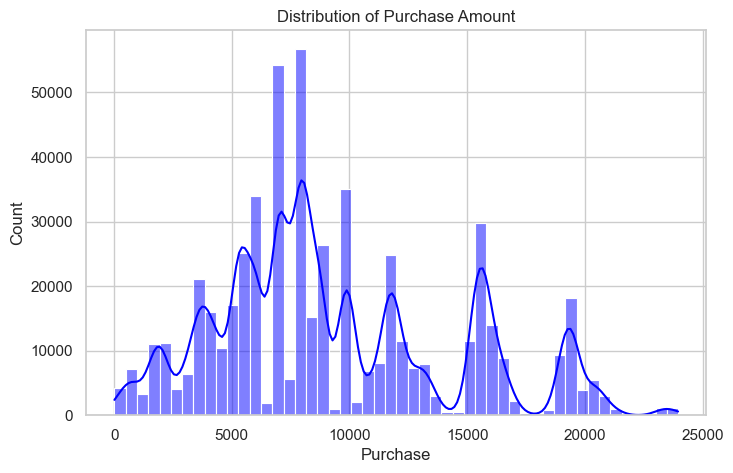

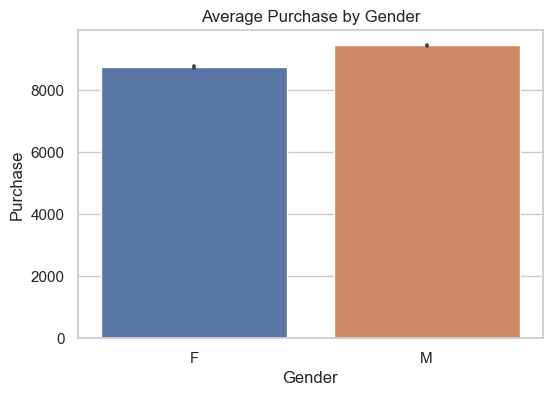

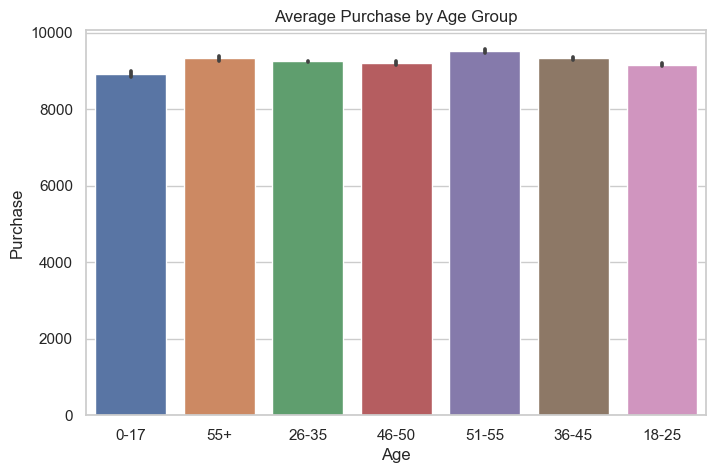

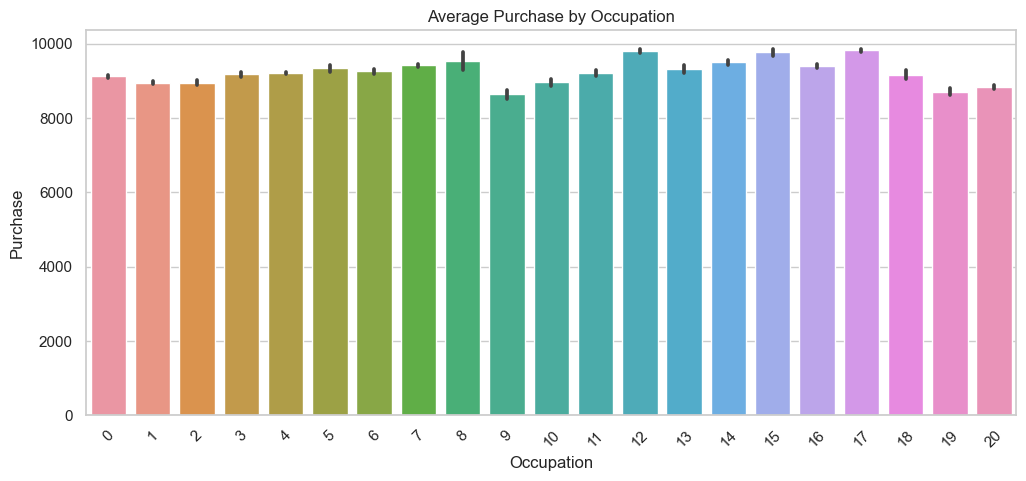

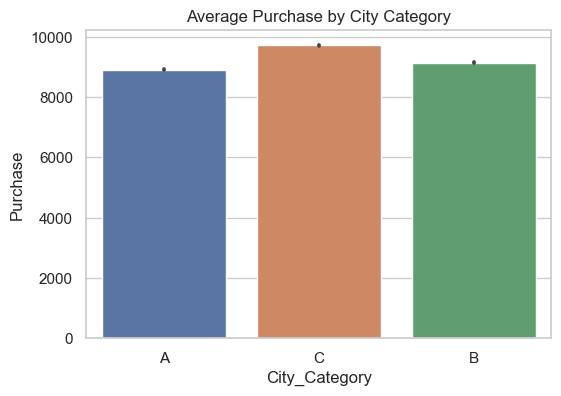

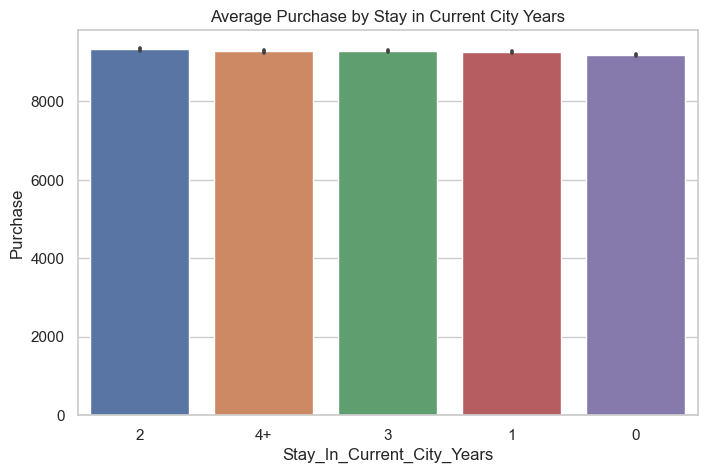

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1. Distribution of Purchase
plt.figure(figsize=(8,5))
sns.histplot(train["Purchase"], bins=50, kde=True, color="blue")
plt.title("Distribution of Purchase Amount")
plt.show()

# 2. Gender vs Average Purchase
plt.figure(figsize=(6,4))
sns.barplot(x="Gender", y="Purchase", data=train)
plt.title("Average Purchase by Gender")
plt.show()

# 3. Age vs Purchase
plt.figure(figsize=(8,5))
sns.barplot(x="Age", y="Purchase", data=train, estimator=np.mean)
plt.title("Average Purchase by Age Group")
plt.show()

# 4. Occupation vs Purchase
plt.figure(figsize=(12,5))
sns.barplot(x="Occupation", y="Purchase", data=train, estimator=np.mean)
plt.xticks(rotation=45)
plt.title("Average Purchase by Occupation")
plt.show()

# 5. City Category vs Purchase
plt.figure(figsize=(6,4))
sns.barplot(x="City_Category", y="Purchase", data=train)
plt.title("Average Purchase by City Category")
plt.show()

# 6. Stay in Current City Years vs Purchase
plt.figure(figsize=(8,5))
sns.barplot(x="Stay_In_Current_City_Years", y="Purchase", data=train)
plt.title("Average Purchase by Stay in Current City Years")
plt.show()


